In [1]:
import numpy as np
import mylibrary.nnlib as tnn
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import copy

matplotlib.rcParams['figure.figsize'] = (12, 8)

In [2]:
num_points = 50
X1 = np.linspace(-2.5, 1.5, num_points)
X2 = np.linspace(-2, 4, num_points)
X1, X2 = np.meshgrid(X1, X2)
Y = np.sin(np.sqrt(X1**2 + X2**2))*2-1.

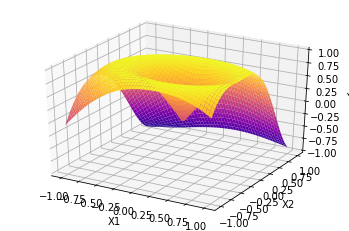

In [3]:
####Scaling the data to range -1,1
X1 = 2*(X1 - X1.min())/(X1.max() - X1.min()) -1
X2 = 2*(X2 - X2.min())/(X2.max() - X2.min()) -1
Y = 2*(Y - Y.min())/(Y.max() - Y.min()) -1

x1 = X1.reshape(-1)
x2 = X2.reshape(-1)

xx = np.c_[x1, x2]
yy = Y.reshape(-1,1)

%matplotlib inline
fig = plt.figure()
ax = fig.gca(projection='3d')
# ax.scatter(X1, X2, Y)
ax.plot_surface(X1, X2, Y, cmap='plasma')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
plt.show()

## Find best split with gradient descent -- scale error around break point with gaussian

In [19]:
# optim = tnn.SGD(0.1)
# optim = tnn.Adam(0.001, 0.5, 0.999)
optim = tnn.Adam(0.01)
linear = tnn.LinearLayer(2,1,optimizer=optim)

optim = tnn.Adam(0.03)
line0 = tnn.LinearLayer(2,1, optimizer=optim)
line1 = tnn.LinearLayer(2,1, optimizer=optim)
# line0.weights *= 0
# line1.weights *= 0

gaussian = tnn.Gaussian()

In [21]:
%matplotlib tk
fig = plt.figure()
ax = fig.gca(projection='3d')

for epoch in range(100000):

    lout = linear.forward(xx)
    err_scaler = gaussian.forward(lout) ### ??? same as sigmoid based 
#     err_scaler = 1
    
#     line0.weights *= 0
#     line1.weights *= 0
    
    mask0 = lout>0
    mask1 = ~mask0    
    
    l0 = line0.forward(xx)
    l1 = line1.forward(xx)
    y0 = l0*mask0
    y1 = l1*mask1
    
    yout = y0 + y1
    
    dy = yout - yy
    
    
    dy0 = dy
    dy1 = dy
    
    dl0 = dy0*(mask0)
    dl1 = dy1*(mask1)
    
    ########11111111111111
#     dxl = linear.backward(dy*err_scaler)#*0.25)
#     dx0 = line0.backward(dl0)
#     dx1 = line1.backward(dl1)
#     dx = dxl + dx0  + dx1

    ########222222222222222
#     a = (dy*xx.sum(axis=1, keepdims=True))*err_scaler
#     d = (dy*xx).sum(axis=1, keepdims=True)*err_scaler
#     np.testing.assert_almost_equal(a, d, err_msg='not same')
#     break
#     dyl = (dy*xx.sum(axis=1, keepdims=True) + dy)/3*err_scaler
#     dyl = (dy*xx).sum(axis=1, keepdims=True)/2*err_scaler
#     dyl = dy*err_scaler
    dyl = (dy*mask0-dy*mask1)*err_scaler

    dxl = linear.backward(dyl)#/0.25)
    
    dx0 = line0.backward(dl0)
    dx1 = line1.backward(dl1)
    dx = dxl + dx0  + dx1
    
    linear.update()
    line0.update()
    line1.update()
    
    if epoch%100 == 0:
        
        error = (dy**2).mean()
        print(epoch, 'Error = ', error)
        ax.clear()
        
        ax.scatter(X1, X2, Y)
        ax.scatter(X1, X2, yout.reshape(-1), color='r', marker='.')
        
        ax.set_xlabel('X1')
        ax.set_ylabel('X2')
        ax.set_zlabel('Y')
        
        fig.canvas.draw()
        plt.pause(0.01)
        print("\n")
        if error < 0.00025:
            print('fitted to our expectation')
            break

0 Error =  0.04751498150999945


100 Error =  0.038736842979934114


200 Error =  0.03774856430134993


300 Error =  0.037406718769608736


400 Error =  0.03720876320957419


500 Error =  0.03699000626894574


600 Error =  0.03682549853106251


700 Error =  0.03679960446226557


800 Error =  0.03668983818387606


900 Error =  0.03659618147168383


TclError: invalid command name "."

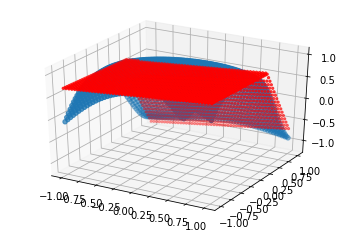

In [34]:
%matplotlib inline
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(X1, X2, Y)
ax.scatter(X1, X2, yout.reshape(-1), color='r', marker='.')
plt.show()

In [27]:
linear.weights, linear.bias

(array([[-0.15607643],
        [-5.98446732]]), array([2.42593717]))

## Sigmoid based,, it has gaussian gradient scaling

In [9]:
# optim = tnn.SGD(0.1)
optim = tnn.Adam(0.01)
linear = tnn.LinearLayer(2,1,optimizer=optim)
# linear.weights*=0

# optim = tnn.Adam(0.01)
line0 = tnn.LinearLayer(2,1, optimizer=optim)
line1 = tnn.LinearLayer(2,1, optimizer=optim)
line0.weights *= 0
line1.weights *= 0

sigmoid = tnn.Sigmoid()

In [10]:
%matplotlib tk
fig = plt.figure()
ax = fig.gca(projection='3d')

for epoch in range(100000):
    
#     line0.weights *= 0
#     line1.weights *= 0

    lout = sigmoid.forward(linear.forward(xx))
    
    mask0 = lout>0.5 ## equivalent to double relu splits
    mask1 = ~mask0    
       
    l0 = line0.forward(xx)
    l1 = line1.forward(xx)
    y0 = l0*mask0
    y1 = l1*mask1
    
    yout = y0 + y1
    
    dy = yout - yy
    
    
    dy0 = dy
    dy1 = dy
    
    dl0 = dy0*(mask0)
    dl1 = dy1*(mask1)
    
#     dys = y0*dy + y1*dy
#     dys = dy
#     dys = dy*(xx.sum(axis=1, keepdims=True) + 1)/3
    dys = dy*(xx.sum(axis=1, keepdims=True))/3

    
    dyl = sigmoid.backward(dys)
    dxl = linear.backward(dyl)#/0.25)
    dx0 = line0.backward(dl0)
    dx1 = line1.backward(dl1)
    dx = dxl + dx0  + dx1
    
    linear.update()
    line0.update()
    line1.update()
    
    dy = yout - yy
    
    if epoch%100 == 0:
        
        error = (dy**2).mean()
        print(epoch, 'Error = ', error)
        ax.clear()
        
        ax.scatter(X1, X2, Y)
        ax.scatter(X1, X2, yout.reshape(-1), color='r', marker='.')
        
        ax.set_xlabel('X1')
        ax.set_ylabel('X2')
        ax.set_zlabel('Y')
        
        fig.canvas.draw()
        plt.pause(0.01)
        print("\n")
        if error < 0.00025:
            print('fitted to our expectation')
            break

0 Error =  0.5639648664243325


100 Error =  0.1288526534650755


200 Error =  0.1429431963854122


300 Error =  0.10411369658667341


400 Error =  0.07773463899697342


500 Error =  0.06257099156209346


600 Error =  0.06603567894124872


700 Error =  0.08037334997634066


800 Error =  0.09203719568821939


900 Error =  0.10020105696644035


TclError: invalid command name "."

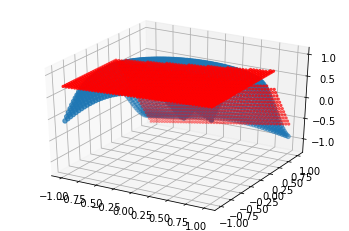

In [36]:
%matplotlib inline
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(X1, X2, Y)
ax.scatter(X1, X2, yout.reshape(-1), color='r', marker='.')
plt.show()

In [37]:
linear.weights, linear.bias

(array([[ 1.1211051 ],
        [-7.27739512]]), array([2.63832617]))

## DTR Hard diff

In [44]:
optimizer = tnn.Adam()
prob = tnn.LinearLayer(2,1,optimizer=optimizer)
linear0 = tnn.LinearLayer(1,1, optimizer=optimizer)
linear1 = tnn.LinearLayer(1,1, optimizer=optimizer)

bias = tnn.BiasLayer(1, optimizer=optimizer)
# gaussian = tnn.Gaussian()

In [45]:
%matplotlib tk
fig = plt.figure()
ax = fig.gca(projection='3d')

for epoch in range(100000):

    pout = prob.forward(xx)
    ## Using this makes the function continuous
    ## Breaking this makes it discontinuous
#     linear0.bias*=0.
#     linear1.bias*=0.
##     bias.bias *= 0

#     linear0.weights *=0.
#     linear1.weights *=0.
    
    l0 = linear0.forward(pout)
    l1 = linear1.forward(pout)
    
    mask0 = pout>0
    mask1 = ~mask0    

    y0 = l0*mask0
    y1 = l1*mask1
    
    yout_ = y0 + y1
    yout = bias.forward(yout_)
    
    dy = yout - yy
    
    dy_ = bias.backward(dy)
    dy0 = dy_
    dy1 = dy_
    
    dl0 = dy0*(mask0)
    dl1 = dy1*(mask1)
    
    dpout0 = linear0.backward(dl0)
    dpout1 = linear1.backward(dl1)
    
#     dpout_ = dy0*l0*mask0 + dy1*l1*mask1
    
    dpout = dpout0 + dpout1
#     dpout = dy
    dx = prob.backward(dpout)#*gaussian.forward(pout))
    
    prob.update()
    linear0.update()
    linear1.update()
    bias.update()

    if epoch%100 == 0:
        
        error = (dy**2).mean()
        print(epoch, 'Error = ', error)
        ax.clear()
        
        ax.scatter(X1, X2, Y)
        ax.scatter(X1, X2, yout.reshape(-1), color='r', marker='.')
        
        ax.set_xlabel('X1')
        ax.set_ylabel('X2')
        ax.set_zlabel('Y')
        
        fig.canvas.draw()
        plt.pause(0.01)
        print("\n")
        if error < 0.00025:
            print('fitted to our expectation')
            break

0 Error =  1.2630306274906693


100 Error =  0.3724814588533509


200 Error =  0.2497419631794644


300 Error =  0.12695416005427548


400 Error =  0.051778764506359015


500 Error =  0.039391415464212355


600 Error =  0.03900285446028517


700 Error =  0.038915843755584635


800 Error =  0.03891513152096468


900 Error =  0.038915130859311274


1000 Error =  0.03891513085919447


1100 Error =  0.03891513085919447


1200 Error =  0.03891513085919447


1300 Error =  0.03891513085919447


1400 Error =  0.03891513085919447


1500 Error =  0.03891513085919447


TclError: invalid command name "."

## Gaussian, decision boundary, continued regression

In [47]:
# optim = tnn.SGD(0.1)
optim = tnn.Adam(0.01)
linear = tnn.LinearLayer(2,1,optimizer=optim)

# optim = tnn.Adam(0.01)
line0 = tnn.LinearLayer(1,1, optimizer=optim)
line1 = tnn.LinearLayer(1,1, optimizer=optim)
# line0.weights *= 0
# line1.weights *= 0

gaussian = tnn.Gaussian()

In [48]:
%matplotlib tk
fig = plt.figure()
ax = fig.gca(projection='3d')

for epoch in range(100000):

    lout = linear.forward(xx)
    err_scaler = gaussian.forward(lout) ### ??? same as sigmoid based 
#     err_scaler = 1
    
#     line0.weights *= 0
#     line1.weights *= 0
    
    mask0 = lout>0
    mask1 = ~mask0    
    
    l0 = line0.forward(lout)
    l1 = line1.forward(lout)
    y0 = l0*mask0
    y1 = l1*mask1
    
    yout = y0 + y1
    
    dy = yout - yy
    
    
    dy0 = dy
    dy1 = dy
    
    dl0 = dy0*(mask0)
    dl1 = dy1*(mask1)
    
    dlout0 = line0.backward(dl0)
    dlout1 = line1.backward(dl1)
    dlout = dlout0 + dlout1
    
    dxl = linear.backward(dlout*err_scaler)#*0.25)
    dx = dxl + dx0  + dx1
    
    linear.update()
    line0.update()
    line1.update()
    
    if epoch%100 == 0:
        
        error = (dy**2).mean()
        print(epoch, 'Error = ', error)
        ax.clear()
        
        ax.scatter(X1, X2, Y)
        ax.scatter(X1, X2, yout.reshape(-1), color='r', marker='.')
        
        ax.set_xlabel('X1')
        ax.set_ylabel('X2')
        ax.set_zlabel('Y')
        
        fig.canvas.draw()
        plt.pause(0.01)
        print("\n")
        if error < 0.00025:
            print('fitted to our expectation')
            break

0 Error =  11.095540708033724


100 Error =  0.3367259376110902


200 Error =  0.19081702382047844


300 Error =  0.15617889218990527


400 Error =  0.12921270001503796


500 Error =  0.08156798553092556


600 Error =  0.0712250380418276


700 Error =  0.0663791535579783


800 Error =  0.06143027043046627


900 Error =  0.056567344305710414


1000 Error =  0.05181252103599602


1100 Error =  0.04788652172564782


1200 Error =  0.04478348969873998


1300 Error =  0.04253215783558817


1400 Error =  0.04132380533702542


1500 Error =  0.04084570096063809


1600 Error =  0.04042147506435327


1700 Error =  0.04020027801352965


1800 Error =  0.040194523245196026


1900 Error =  0.040184007649698865


2000 Error =  0.04006771067975974


2100 Error =  0.03998868229273871


2200 Error =  0.0400069788807979


2300 Error =  0.040026941059109866


2400 Error =  0.04002751377471055


2500 Error =  0.040015332816763706


TclError: invalid command name "."

### Sigmoid decision boundary scaling

In [51]:
# optim = tnn.SGD(0.1)
optim = tnn.Adam(0.01)
linear = tnn.LinearLayer(2,1,optimizer=optim)

line0 = tnn.LinearLayer(1,1, optimizer=optim)
line1 = tnn.LinearLayer(1,1, optimizer=optim)
line0.weights *= 0
line1.weights *= 0

sigmoid = tnn.Sigmoid()

In [52]:
%matplotlib tk
fig = plt.figure()
ax = fig.gca(projection='3d')

for epoch in range(100000):

    lout = linear.forward(xx)
    pout = sigmoid.forward(lout)
#     err_scaler = 1
    
#     line0.weights *= 0
#     line1.weights *= 0
    
    mask0 = lout>0
    mask1 = ~mask0    
    
    l0 = line0.forward(lout)
    l1 = line1.forward(lout)
    y0 = l0*mask0
    y1 = l1*mask1
    
    yout = y0 + y1
    
    dy = yout - yy
    
    
    dy0 = dy
    dy1 = dy
    
    dl0 = dy0*(mask0)
    dl1 = dy1*(mask1)
    
    dlout0 = line0.backward(dl0)
    dlout1 = line1.backward(dl1)
    dlout = dlout0 + dlout1
    
    dpout = sigmoid.backward(dlout)
    dxl = linear.backward(dpout)
    
    linear.update()
    line0.update()
    line1.update()
    
    if epoch%100 == 0:
        
        error = (dy**2).mean()
        print(epoch, 'Error = ', error)
        ax.clear()
        
        ax.scatter(X1, X2, Y)
        ax.scatter(X1, X2, yout.reshape(-1), color='r', marker='.')
        
        ax.set_xlabel('X1')
        ax.set_ylabel('X2')
        ax.set_zlabel('Y')
        
        fig.canvas.draw()
        plt.pause(0.01)
        print("\n")
        if error < 0.00025:
            print('fitted to our expectation')
            break

0 Error =  0.5639648664243325


100 Error =  0.06451493800317928


200 Error =  0.05028898394023338


300 Error =  0.05126208974790479


400 Error =  0.05161120285266024


500 Error =  0.0510111637160141


600 Error =  0.050109010444659506


700 Error =  0.04913832443526029


800 Error =  0.04863750030601675


900 Error =  0.04793684125406372


1000 Error =  0.04680562238622188


1100 Error =  0.04567616502201741


1200 Error =  0.04503259544237595


1300 Error =  0.04443452472813182


1400 Error =  0.04332936789656413


1500 Error =  0.042678151217365776


1600 Error =  0.04211584361923237


1700 Error =  0.041313551224137664


1800 Error =  0.04090651441867034


1900 Error =  0.04040218778809741


2000 Error =  0.04008174803246581


2100 Error =  0.03980766852906298


2200 Error =  0.039624873348823614


2300 Error =  0.039514297479351285


2400 Error =  0.03942728988701449


2500 Error =  0.039373478303682125


2600 Error =  0.039375287737382164


2700 Error =  0.039421415574878535


TclError: invalid command name "."

In [53]:
linear.weights

array([[-0.80248297],
       [ 6.83933973]])

## Soft Decision Tree Style

In [8]:
# optim = tnn.SGD(0.1)
optim = tnn.Adam(0.01)
linear = tnn.LinearLayer(2,1,optimizer=optim)
# linear.weights*=0

optim = tnn.Adam(0.03)
line0 = tnn.LinearLayer(2,1, optimizer=optim)
line1 = tnn.LinearLayer(2,1, optimizer=optim)
# line0.weights *= 0
# line1.weights *= 0

sigmoid = tnn.Sigmoid()

In [9]:
%matplotlib tk
fig = plt.figure()
ax = fig.gca(projection='3d')

for epoch in range(100000):
    
    lout = sigmoid.forward(linear.forward(xx))
    
    mask0 = lout>0.5 ## equivalent to double relu splits
    mask1 = ~mask0    
       
    l0 = line0.forward(xx)
    l1 = line1.forward(xx)
    y0 = l0*mask0
    y1 = l1*mask1
    
    yout = y0 + y1
    
    dy = yout - yy
    
    
    dy0 = dy
    dy1 = dy
    
    dl0 = dy0*(mask0)
    dl1 = dy1*(mask1)
    
    dys = l0*dy-l1*dy 
    dyl = sigmoid.backward(dys)
    dxl = linear.backward(dyl)#/0.25)
    dx0 = line0.backward(dl0)
    dx1 = line1.backward(dl1)
    dx = dxl + dx0  + dx1
    
    linear.update()
    line0.update()
    line1.update()
    
    dy = yout - yy
    
    if epoch%100 == 0:
        
        error = (dy**2).mean()
        print(epoch, 'Error = ', error)
        ax.clear()
        
        ax.scatter(X1, X2, Y)
        ax.scatter(X1, X2, yout.reshape(-1), color='r', marker='.')
        ax.scatter(X1, X2, dyl.reshape(-1), color='c', marker='.')
        
        
        ax.set_xlabel('X1')
        ax.set_ylabel('X2')
        ax.set_zlabel('Y')
        
        fig.canvas.draw()
        plt.pause(0.01)
        print("\n")
        if error < 0.00025:
            print('fitted to our expectation')
            break

0 Error =  2.637556458437808


100 Error =  0.08377420345984615


200 Error =  0.0690557264137743


300 Error =  0.05702029987259952


400 Error =  0.050814311990976704


500 Error =  0.04374730218014143


600 Error =  0.04124966797835673


700 Error =  0.03844386268163485


800 Error =  0.03717740668695638


900 Error =  0.03668343865908631


1000 Error =  0.036485548474303096


1100 Error =  0.03669088546600963


1200 Error =  0.03685350972476962


1300 Error =  0.036900305568250275


1400 Error =  0.036889825435880104


1500 Error =  0.03685888069308669


1600 Error =  0.03678880599483459


1700 Error =  0.03679909903763951


1800 Error =  0.036756779707218495


1900 Error =  0.03671507789462605


2000 Error =  0.03667432792520736


2100 Error =  0.03669065494194832


2200 Error =  0.03670504055725275


2300 Error =  0.03675024951609679


2400 Error =  0.03679984441120524


2500 Error =  0.036806842945705076


2600 Error =  0.03680164631961902


2700 Error =  0.0367945113857012


28

TclError: invalid command name "."